In [110]:
#          0      1      2      3      4      5       6      7      8      9       10      11      12
coins = ['BTC', 'ETH', 'BNB', 'DOT', 'SOL', 'LUNA', 'ADA', 'CRO', 'AXS', 'SAND', 'DOGE', 'SHIB', 'MATIC']

In [148]:
from hypecommons import download_history_fast
import pandas as pd
import re
import os

START_TIME = '2021-12-16 01:00:00'
BASE = 'BUSD'
MOV_AVG_PERIODS = 24 * 3
HOURS_AHEAD = MOV_AVG_PERIODS

coin = coins[1]

# sentiment analysis indices
df_i = pd.read_csv(f"s-analysis/indices-{coin}-003.csv")
df_i['dt'] = pd.to_datetime(df_i['dt'])
df_i = df_i.set_index('dt')

EXPERIMENT_ID = f"{coin}-{BASE}-{MOV_AVG_PERIODS}ma-{HOURS_AHEAD}h-{df_i.index[-1].strftime('%Y%m%d%H%M%S')}"
os.makedirs(f"plots/{EXPERIMENT_ID}", exist_ok=True)

EXPERIMENT_ID

'ETH-BUSD-72ma-72h-20220206130000'

In [149]:
for col in df_i:
#     df_i[col] = (df_i[col] - df_i[col].mean()) / df_i[col].std()
    df_i[f"sent/{col}"] = df_i[col].rolling(window=MOV_AVG_PERIODS).mean()
    df_i.drop(col, inplace=True, axis=1)

# price history
df_h = download_history_fast(f"{coin}{BASE}", re.sub("[^0-9]", "", START_TIME), days=(len(df_i)+HOURS_AHEAD)/24)
for col in ['open', 'high', 'low']:
    df_h.drop(col, inplace=True, axis=1)
for col in df_h:
    df_h[f"tech/{col}"] = df_h[col]
    df_h.drop(col, inplace=True, axis=1)

df = df_h.join(df_i)

In [150]:
df_gt = pd.DataFrame()
df_gt_orig = pd.read_csv('google-trends/training.csv')
df_gt['google/trends'] = df_gt_orig[coin] / 100
df_gt['date'] = pd.to_datetime(df_gt_orig['date'])
df_gt = df_gt.set_index('date')

df_gt = df_gt.resample('1H').ffill()
df_gt['google/trends'] = df_gt['google/trends'].shift(24)
df_gt.dropna(inplace=True)

df = df.join(df_gt)

In [151]:
df_tc = pd.read_csv(f"tweet-counts/joined-{coin}.csv")
df_tc['end'] = pd.to_datetime(df_tc['end'])
df_tc['twitter/count'] = df_tc['tweet_count']
df_tc = df_tc.set_index('end').tz_localize(None)
df_tc.drop(['start', 'tweet_count'], axis=1, inplace=True)
df = df.join(df_tc)

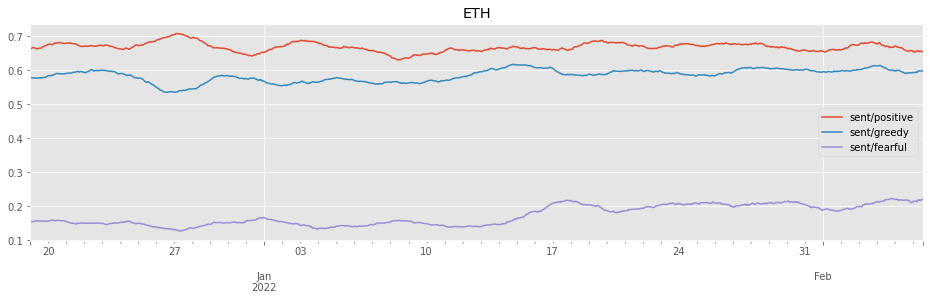

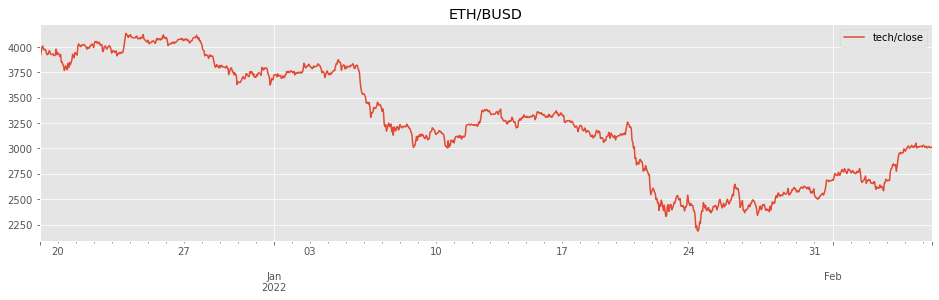

In [152]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 4)

df_sent = df[['sent/positive', 'sent/greedy', 'sent/fearful', 'tech/close']].dropna()

ax = df_sent[['sent/positive', 'sent/greedy', 'sent/fearful']].plot(title=coin)
ax.xaxis.label.set_visible(False)
plt.legend(loc='best')
plt.show()

ax = df_sent['tech/close'].dropna().plot(title=f"{coin}/{BASE}")
ax.xaxis.label.set_visible(False)
plt.legend(loc='best')
plt.savefig(f"plots/{EXPERIMENT_ID}/price.png", bbox_inches = "tight")
plt.show()

In [153]:
def ema(data, n):
    alpha = 2 / (1 + n)
    return data.ewm(alpha=alpha, adjust=False).mean()

def rsi(data, n):
    # Make the positive gains (up) and negative gains (down) Series
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # Calculate the EWMA
    roll_up1 = up.ewm(span=n).mean()
    roll_down1 = down.abs().ewm(span=n).mean()

    # Calculate the RSI based on EWMA
    rs1 = roll_up1 / roll_down1
    return 1.0 - (1.0 / (1.0 + rs1))

def technical_analysis(df):
    macd = ema(df['tech/close'], 12) - ema(df['tech/close'], 26)
    df['techan/macd_norm'] = macd / df['tech/close']
    df['techan/macd_histo_norm'] = (macd - ema(macd, 9)) / df['tech/close']

    boll = df['tech/close'].rolling(window=20)
    boll_2std = 2.0 * boll.std()
    df['techan/bollinger_low_score'] = df['tech/close'] / (boll.mean() - boll_2std)
    df['techan/bollinger_mid_score'] = df['tech/close'] / (boll.mean())
    df['techan/bollinger_high_score'] = df['tech/close'] / (boll.mean() + boll_2std)
    del boll, boll_2std

    df['techan/rsi14'] = rsi(df['tech/close'], 14)
    
    return df

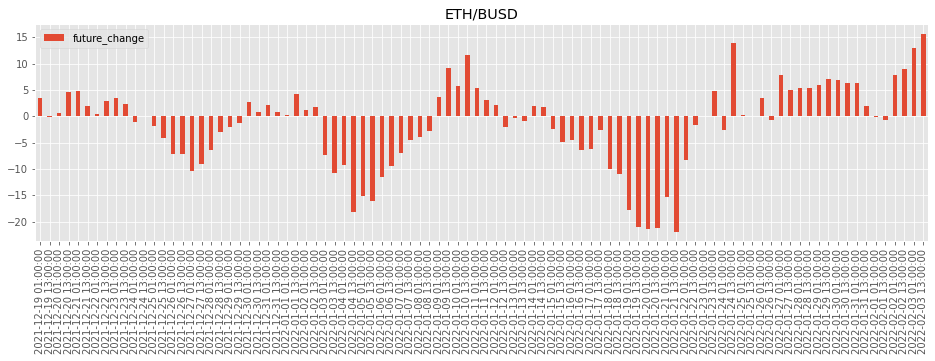

In [154]:
df_x = df.copy()
df_x = technical_analysis(df_x)

for col in ['tech/volume', 'tech/trades', 'twitter/count']:
    # TODO calculate MAX over the training set, not the full set
    df_x[col] = df_x[col] / df_x[col].max()
    df_x[f"{col}_osc_ma"] = df_x[col].rolling(window=MOV_AVG_PERIODS).mean()

df_x['tech/change'] = df_x['tech/close'].diff(HOURS_AHEAD) / df_x['tech/close'].shift(HOURS_AHEAD) * 100

df_x['future_change'] = (-df_x['tech/close'].diff(-HOURS_AHEAD) / df_x['tech/close']) * 100
ax = df_x.dropna()[::12]['future_change'].plot.bar(title=f"{coin}/{BASE}")
ax.xaxis.label.set_visible(False)
plt.legend(loc='best')

df_x.dropna(inplace=True)

In [155]:
# from sklearn.linear_model import LinearRegression
# from IPython.display import display

# cols = list(df_i) \
#     + ['tech/change', 'tech/volume_osc_ma', 'tech/trades_osc_ma'] \
#     + ['techan/macd_norm', 'techan/macd_histo_norm', 'techan/rsi14'] \
#     + ['techan/bollinger_low_score', 'techan/bollinger_mid_score', 'techan/bollinger_high_score'] \
#     + ['google/trends', 'twitter/count_osc_ma'] \

# X = df_x[cols]
# y = df_x['future_change']

# model_full = LinearRegression().fit(X, y)
# print(f"Train score: {model_full.score(X, y)}")

# plt.rcParams["figure.figsize"] = (16, 4)

# ax = df_x[['sent/positive', 'sent/hopeful', 'sent/enthusiastic']].plot(title=coin)
# ax.xaxis.label.set_visible(False)
# plt.legend(loc='best')
# plt.show()

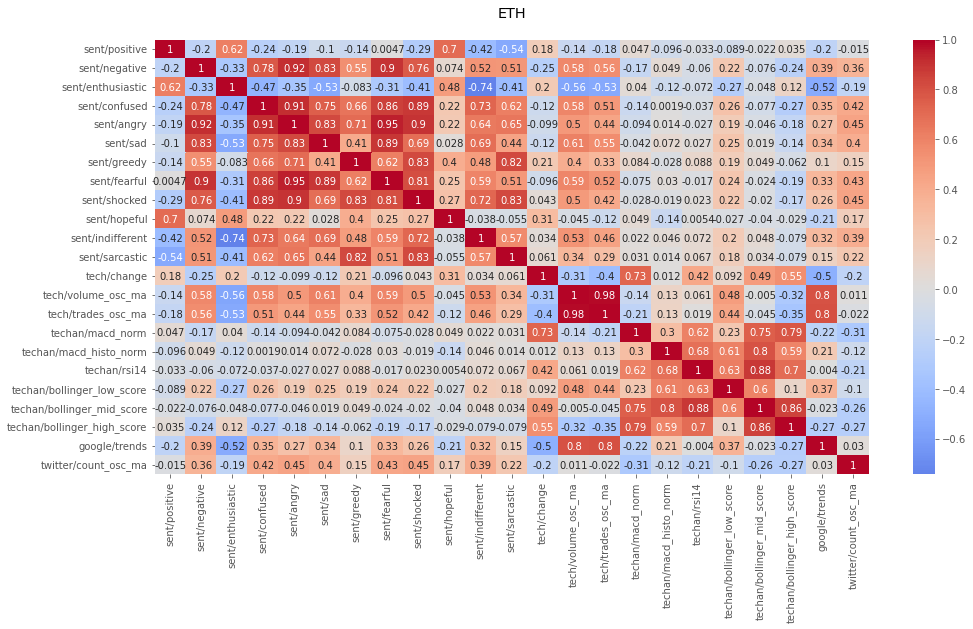

In [156]:
import seaborn as sn

plt.rcParams["figure.figsize"] = (16, 8)

cm = df_x[cols].corr()
sn.heatmap(cm, annot=True, cmap='coolwarm', center=0)
plt.title(coin + '\n')
plt.savefig(f"plots/{EXPERIMENT_ID}/correlation-matrix.png", bbox_inches = "tight")
plt.show()

## Split into train & test, run first simulation

In [120]:
train_size = int(0.7 * len(df_x))

df_train = df_x[:train_size].copy()
df_test = df_x[train_size:].copy()

X = df_train[cols]
y = df_train['future_change']

In [121]:
X_test = df_test[cols]
y_test = df_test['future_change']

In [122]:
export = {'exp_id': EXPERIMENT_ID, 'X_train': X, 'y_train': y, 'X_test': X_test, 'y_test': y_test}

import pickle
with open(f's-analysis/{coin}.pkl', 'wb') as f_out:
    pickle.dump(export, f_out)

### Linear regression

In [123]:
# model = LinearRegression().fit(X, y)
# print(f"Train score: {model.score(X, y)}")
# print(f"Test score:  {model.score(df_test[cols], df_test['future_change'])}")

# df_lr = pd.DataFrame([{'parameter': a, 'weight': b} for a, b in zip(cols, model.coef_)])
# df_lr = df_lr.set_index('parameter')
# display(df_lr.sort_values(by='weight', ascending=False))

# plt.rcParams["figure.figsize"] = (16, 4)

# ax = df_train[['sent/positive', 'sent/hopeful', 'sent/enthusiastic']].plot(title=coin)
# ax.xaxis.label.set_visible(False)
# plt.legend(loc='best')
# plt.show()

In [124]:
# df_test['lr_prediction'] = model.predict(X_test)

# plt.rcParams["figure.figsize"] = (16, 4)

# ax = df_test[['future_change', 'lr_prediction']][::6].plot.bar(title=f"{coin}/{BASE}")
# ax.set_ylabel(f"% change after {HOURS_AHEAD} hours")
# plt.show()

### Multilayer perceptron

In [125]:
# from sklearn.neural_network import MLPRegressor

# regr = MLPRegressor(random_state=1, max_iter=5000).fit(X, y)

# print(f"Test score:  {regr.score(X_test, y_test)}")

In [126]:
# df_test['mlp_prediction'] = regr.predict(X_test)

# plt.rcParams["figure.figsize"] = (16, 4)

# ax = df_test[['future_change', 'mlp_prediction']][::6].plot.bar(title=f"{coin}/{BASE}")
# ax.set_ylabel(f"% change after {HOURS_AHEAD} hours")
# plt.show()

### Feature selection

In [127]:
# from sklearn.feature_selection import f_regression, SelectKBest

# # configure to select all features
# fs = SelectKBest(score_func=f_regression, k=10)
# # learn relationship from training data
# fs.fit(X, y)
# # transform train input data
# X_train_fs = fs.transform(X)
# # transform test input data
# X_test_fs = fs.transform(X_test)

# # what are scores for the features
# df_feat = pd.DataFrame(
#     [{'feature': col, 'score': fs.scores_[i] / max(fs.scores_)} for i, col in enumerate(cols)]
# ).sort_values(by='score', ascending=False)

# X_train_fs.shape

In [128]:
# # plot the scores
# plt.rcParams["figure.figsize"] = (12, 12)
# plt.barh(df_feat['feature'], df_feat['score'])
# plt.yticks(fontsize=14)
# plt.gca().invert_yaxis()
# plt.title(f"{coin} :: Feature Importance")
# plt.show()

### Feature selection + MLP

In [129]:
# regr_fs = MLPRegressor(random_state=1, max_iter=10000).fit(X_train_fs, y)

# print(f"Test score:  {regr_fs.score(X_test_fs, y_test)}")

In [130]:
# df_test['mlp_fs_prediction'] = regr_fs.predict(X_test_fs)

# plt.rcParams["figure.figsize"] = (16, 4)

# ax = df_test[['future_change', 'mlp_fs_prediction']][::6].plot.bar(title=f"{coin}/{BASE}")
# ax.set_ylabel(f"% change after {HOURS_AHEAD} hours")
# plt.show()

### Feature selection + LR

In [131]:
# model_fs = LinearRegression().fit(X_train_fs, y)

# print(f"Test score:  {model_fs.score(X_test_fs, y_test)}")

In [132]:
# df_test['lr_fs_prediction'] = model_fs.predict(X_test_fs)

# plt.rcParams["figure.figsize"] = (16, 4)

# ax = df_test[['future_change', 'lr_fs_prediction']][::6].plot.bar(title=f"{coin}/{BASE}")
# ax.set_ylabel(f"% change after {HOURS_AHEAD} hours")
# plt.show()

In [133]:
# print(f"lr score:  {model.score(X_test, y_test)}")
# print(f"mlp score:  {regr.score(X_test, y_test)}")
# print(f"lr_fs score:  {model_fs.score(X_test_fs, y_test)}")
# print(f"mlp_fs score:  {regr_fs.score(X_test_fs, y_test)}")

#### range 001
```
lr score:  0.33030269182479666
mlp score:  -0.37882974617498744
lr_fs score:  0.7833508471210721
mlp_fs score:  0.07699897807117662
```